After confirm that our implementation is OK, now we want to test the performance (velocity) of the different usages (with and without) analytical models.

We perform three calculations:
    1. Only MGE decomposition
    2. MGE + Elliptical NFW (eNFW)
    3. MGE + pseudo elliptical (pENFW)

In [1]:
import autolens as al
import autolens.plot as aplt
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import z_at_value
from astropy.cosmology import Planck15 as cosmo
import time

In [2]:
grid = al.Grid.uniform(shape_2d=(80, 80), pixel_scales=0.09, sub_size=1)

In [3]:
#Reading MGE inputs
surf_lum, sigma_lum, qobs_lum = np.loadtxt("JAM_Input.txt", unpack=True)           #MGE decomposition
surf_dm, sigma_dm , qobs_dm   = np.loadtxt("eNFW.txt", unpack=True)     #DM component

In [4]:
#Input
#Only for lensing modelling 
z_l    = 0.299                                                         #Lens Redshift
z_s    = 3.100                                                         #Source Redshift 
D_l    = cosmo.angular_diameter_distance(z_l).value                    #Distance to lens [Mpc] 
mbh    = 1e9                                                           #mass of black hole [log10(M_sun)]
kappa_ = 1.00                                                         #kappa_s of DM halo
r_s    = 11.5                                                          #scale radius os dm halo
ml     = 7.7                                                           #mass to light ratio
shear_comp = al.convert.shear_elliptical_comps_from(magnitude=0.02, phi=88) #external shear

# Only MGE parametrization

In [5]:
#Initializing
mass_profile_MGE = al.mp.MGE()


#Components
mass_profile_MGE.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml,
                       mbh=mbh, surf_dm=kappa_*surf_dm, sigma_dm=sigma_dm, qobs_dm=qobs_dm)

In [6]:
#One run to start Jit functions and don't impact down the real time.
star_jit_MGE = mass_profile_MGE.deflections_from_grid(grid)

In [7]:
n = 1
time_MGE = np.empty(n)
for i in range(n):
    start = time.time()
    mass_profile_MGE.deflections_from_grid(grid)
    time_MGE[i] = time.time() - start

# Elliptical NFW

In [6]:
#Initializing
mass_profile_eNFW = al.mp.MGE()
ell_comps = al.convert.elliptical_comps_from(axis_ratio=qobs_dm[0], phi=0.0) #Elliptical components in Pyautolens units


#Analytical DM
eNFW = al.mp.dark_mass_profiles.EllipticalNFW(kappa_s=kappa_,elliptical_comps=ell_comps, scale_radius=r_s)                

#Components of MGE, only stars
mass_profile_eNFW.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml, mbh=mbh)

#Including analytic model for DM
mass_profile_eNFW.Analytic_Model(analytic_profile=eNFW)

In [8]:
eNFW.scale_radius

11.5

In [9]:
#One run to start Jit functions and don't impact down the real time.
star_jit_eNFW = mass_profile_eNFW.deflections_from_grid(grid)

In [10]:
n = 1
time_eNFW = np.empty(n)
for i in range(n):
    start = time.time()
    mass_profile_eNFW.deflections_from_grid(grid)
    time_eNFW[i] = time.time() - start

# pseudo Elliptical NFW

In [11]:
#Initializing
mass_profile_pENFW = al.mp.MGE()
e = (1 - qobs_dm[0])/2     #Ellipticity of pseudo ellipitical NFW. Aprox valid for e = [0.0, 0.25]
print(e)

#Analytical DM
pENFW = al.mp.dark_mass_profiles.pseudoEllipticalNFW(kappa_s=kappa_, scale_radius=r_s, e=e)                

#Components of MGE, only stars
mass_profile_pENFW.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml, mbh=mbh)

#Including analytic model for DM
mass_profile_pENFW.Analytic_Model(analytic_profile=pENFW)

0.07500000000000001


In [12]:
#One run to start Jit functions and don't impact down the real time.
star_jit_pENFW = mass_profile_pENFW.deflections_from_grid(grid)

In [13]:
n = 1
time_pENFW = np.empty(n)
for i in range(n):
    start = time.time()
    mass_profile_pENFW.deflections_from_grid(grid)
    time_pENFW[i] = time.time() - start

In [14]:
np.savetxt("Time_Elliptical_Models.txt", np.column_stack([time_MGE, time_eNFW, time_pENFW]), header="MGE Time (s) \t eNFW Time (s) \t pENFW Time (s)",
                          fmt="%.4e \t\t %.4e \t\t %.4e")

# Just for check the inversion and the agreement between models

Text(0, 0.5, '$|\\frac{eMGE - eNFW}{eMGE}|$ (%)')

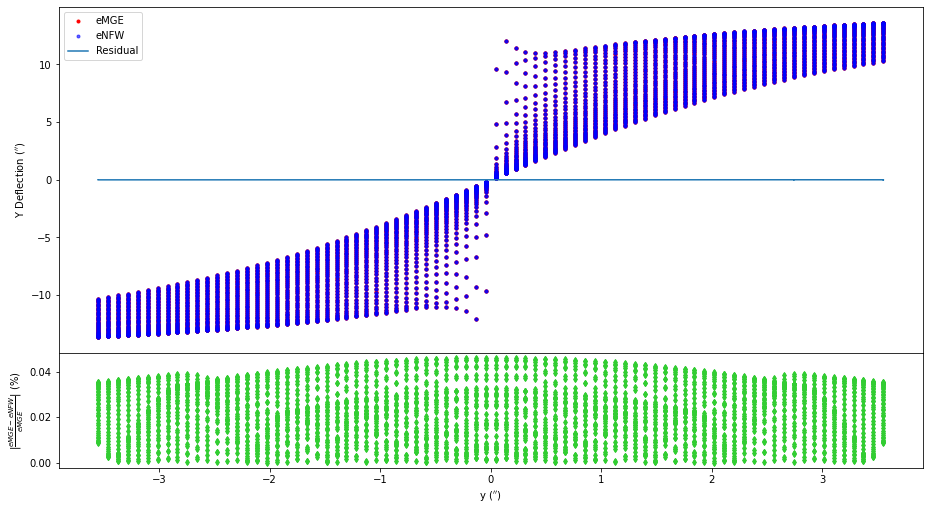

In [20]:
#PLOT
fig1 = plt.figure(figsize=(15,8))

#Plot Data-model
frame1 = fig1.add_axes((.1,.3,.8,.6))
#xstart, ystart, xend, yend [units are fraction of the image frame, from bottom left corner]
plt.plot(grid[:,0],star_jit_MGE[:,0], ".r", label="eMGE")
plt.plot(grid[:,0],star_jit_eNFW[:,0], ".b", label="eNFW", alpha=0.6)
plt.plot(grid[:,0],star_jit_MGE[:,0]-star_jit_eNFW[:,0], label="Residual")

frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
plt.ylabel("Y Deflection ($''$)")
plt.legend()


#Residual plot
frame2 = fig1.add_axes((.1,.1,.8,.2))        
plt.plot(grid[:,0],100 * np.abs((star_jit_MGE[:,0]-star_jit_eNFW[:,0])/star_jit_MGE[:,0]),'d',
                 color='LimeGreen', mec='LimeGreen', ms=4)

plt.xlabel("y ($''$)")
plt.ylabel("$|\\frac{eMGE - eNFW}{eMGE}|$ (%)")

Text(0, 0.5, '$|\\frac{eMGE - pENFW}{eMGE}|$ (%)')

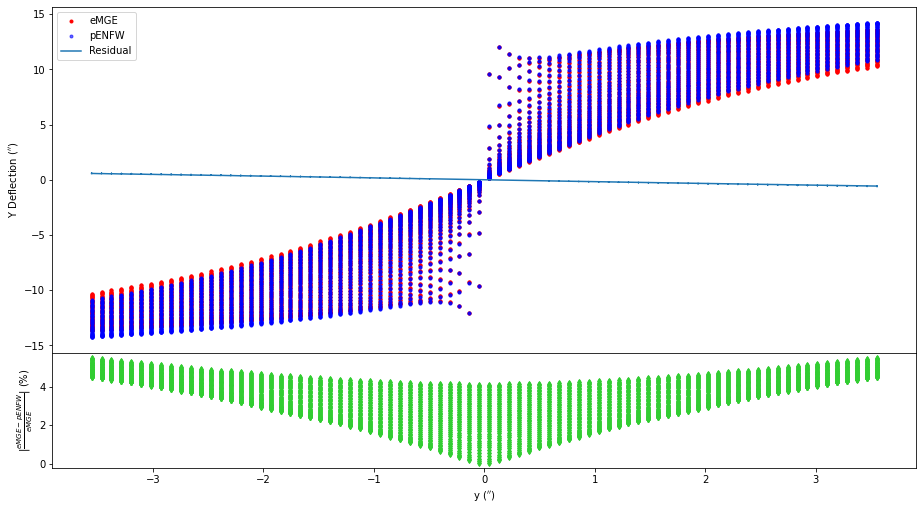

In [19]:
#PLOT
fig1 = plt.figure(figsize=(15,8))

#Plot Data-model
frame1 = fig1.add_axes((.1,.3,.8,.6))
#xstart, ystart, xend, yend [units are fraction of the image frame, from bottom left corner]
plt.plot(grid[:,0],star_jit_MGE[:,0], ".r", label="eMGE")
plt.plot(grid[:,0],star_jit_pENFW[:,0], ".b", label="pENFW", alpha=0.6)
plt.plot(grid[:,0],star_jit_MGE[:,0]-star_jit_pENFW[:,0], label="Residual")

frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
plt.ylabel("Y Deflection ($''$)")
plt.legend()


#Residual plot
frame2 = fig1.add_axes((.1,.1,.8,.2))        
plt.plot(grid[:,0],100 * np.abs((star_jit_MGE[:,0]-star_jit_pENFW[:,0])/star_jit_MGE[:,0]),'d',
                 color='LimeGreen', mec='LimeGreen', ms=4)

plt.xlabel("y ($''$)")
plt.ylabel("$|\\frac{eMGE - pENFW}{eMGE}|$ (%)")

Text(0, 0.5, '$|\\frac{eNFW - pENFW}{eNFW}|$ (%)')

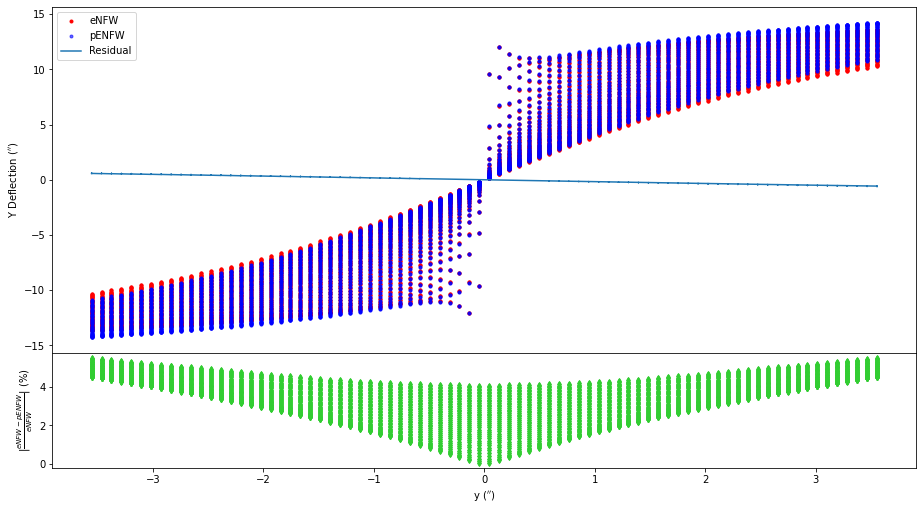

In [18]:
#PLOT
fig1 = plt.figure(figsize=(15,8))

#Plot Data-model
frame1 = fig1.add_axes((.1,.3,.8,.6))
#xstart, ystart, xend, yend [units are fraction of the image frame, from bottom left corner]
plt.plot(grid[:,0],star_jit_eNFW[:,0], ".r", label="eNFW")
plt.plot(grid[:,0],star_jit_pENFW[:,0], ".b", label="pENFW", alpha=0.6)
plt.plot(grid[:,0],star_jit_eNFW[:,0]-star_jit_pENFW[:,0], label="Residual")

frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
plt.ylabel("Y Deflection ($''$)")
plt.legend()


#Residual plot
frame2 = fig1.add_axes((.1,.1,.8,.2))        
plt.plot(grid[:,0],100 * np.abs((star_jit_eNFW[:,0]-star_jit_pENFW[:,0])/star_jit_eNFW[:,0]),'d',
                 color='LimeGreen', mec='LimeGreen', ms=4)

plt.xlabel("y ($''$)")
plt.ylabel("$|\\frac{eNFW - pENFW}{eNFW}|$ (%)")

# PLoting Time for CHE test

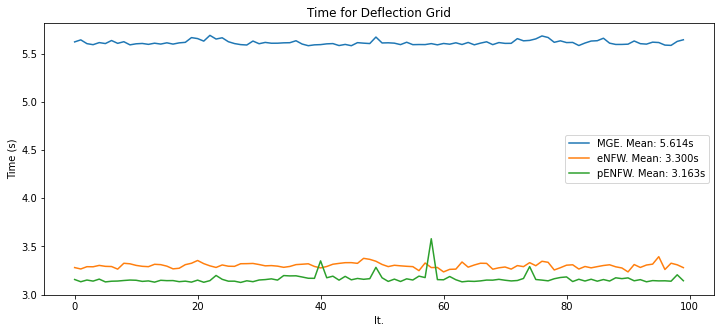

In [22]:
time_MGE, time_eNFW, time_pENFW = np.loadtxt("Time_Elliptical_Models_CHE.txt", unpack=True)

plt.figure(figsize=(12,5))
plt.plot(time_MGE, label="MGE. Mean: %.3fs"%np.mean(time_MGE))
plt.plot(time_eNFW, label="eNFW. Mean: %.3fs"%np.mean(time_eNFW))
plt.plot(time_pENFW, label="pENFW. Mean: %.3fs"%np.mean(time_pENFW))

plt.title("Time for Deflection Grid")
plt.xlabel("It.")
plt.ylabel("Time (s)")
plt.legend()